In [1]:
from CPM import *

GPUを利用します: NVIDIA H100 PCIe


In [2]:
# === デバイス設定 ===
# CUDA (GPU) が利用可能ならGPUを、そうでなければCPUを使用
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"GPUを利用します: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("CPUを利用します")

# === ハイパーパラメータ ===
s_0 = 100.0  # 初期細胞密度（float型を使用）

l_A = 1.0  # 面積エネルギー項の係数λ_A
l_L = 1.0  # 周囲長エネルギー項の係数λ_L (注意: TF版のcalc_cpm_percentでは未使用だった)
A_0 = 150.0  # 目標細胞面積 A_0
L_0 = 42.0  # 目標細胞周囲長 L_0 (注意: TF版のcalc_cpm_percentでは未使用だった)

T = 1.0  # 温度パラメータ T (ボルツマン分布の計算に使用)


GPUを利用します: NVIDIA H100 PCIe


エポック 20/20
現在のマップ（中央部分）:


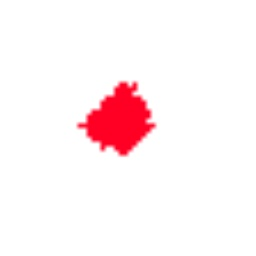

エポック: 100%|██████████| 20/20 [00:00<00:00, 29.83it/s]

密度マップ（中央部分、自動範囲）:

最終状態のマップ:


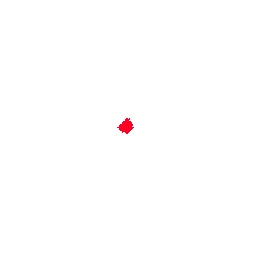


最終状態の密度マップ（自動範囲）:

シミュレーション完了。


In [4]:
map_tensor = map_init(256,256) # マップを初期化
print("初期マップ（中央部分）:")
imshow_map(map_tensor) # 初期状態を表示

num_epochs = 20      # シミュレーションのエポック数
steps_per_epoch = 1 # 1エポックあたりのCPMステップ数
diffusion_steps = 5 # 1 CPMステップあたりの拡散ステップ数

# オプション: 動画記録用ライターの初期化
video_filename = 'cpm_torch_jp.mp4'
if moviepy_available:
    try:
        writer = LoopWriter(filename=video_filename, fps=10, fade_len=0.5) # ループ動画ライター
        print(f"動画を {video_filename} に記録します。")
        record_video = True
    except Exception as e:
        print(f"動画ライターの初期化に失敗しました: {e}")
        record_video = False
else:
    record_video = False
    print("moviepyが利用できないため、動画は記録されません。")

print("map shape ", map_tensor.shape) # マップの形状を表示
# --- シミュレーション実行 ---
for i in tqdm(range(num_epochs), desc="エポック"):
    for k in tqdm(range(steps_per_epoch), desc="CPMステップ", leave=False):

        # --- 拡散ステップ ---
        # 複数の拡散ステップを実行して密度を平滑化
        #for _ in range(diffusion_steps):
        #     map_tensor = diffusion_step(map_tensor, dt=0.1) # dtは拡散の速さ

        # --- CPM更新ステップ ---
        # チェッカーボードパターンで全セルを更新
        for x_offset in range(3): # x方向オフセット (0 or 1)
            for y_offset in range(3): # y方向オフセット (0 or 1)
                # x+y が偶数/奇数のピクセルを交互に更新するイメージ
                # ここのオフセットとパッチ抽出関数のオフセット引数の関係に注意
                # stride=2のチェッカーボード更新に対応させるため、
                # extract_patches_manual_padding_with_offset を使う。
                # オフセット(0,0), (1,0), (0,1), (1,1) で呼び出すと全ピクセルが更新される？ -> 要確認
                # 元のTFコードは slide_h, slide_w を 0, 1, 2 の範囲でループしていた？
                # ここではオフセット(0,0), (1,1) の2回で交互更新を試みる？
                # いや、(0,0), (1,0), (0,1), (1,1) で4つのサブセットを更新するのが正しいか？
                # 元のTFコードに合わせて x, y in range(3) だった？ -> range(2)で試す
                # print("time ", k, "x ", x_offset, "y ", y_offset)
                with torch.no_grad():
                  map_tensor, _ = cpm_checkerboard_step(map_tensor, l_A, A_0, l_L, L_0, T,
                                                      x_offset, y_offset)

        # 数値安定性のため、密度が負にならないようにクランプ
        map_tensor[:, :, 1].clamp_(min=0.0)

    # --- 各エポック終了時の可視化 ---
    if ipython_available:
        clear_output(wait=True) # 出力をクリア
    print(f"エポック {i+1}/{num_epochs}")
    print("現在のマップ（中央部分）:")
    imshow_map(map_tensor[100:156, 100:156]) # IDに基づく色表示
    print("密度マップ（中央部分、自動範囲）:")
    # imshow_map_area_autoRange(map_tensor[100:156, 100:156, 1]) # 密度表示

    # デバッグ情報（コメントアウト）
    # density_vals = map_tensor[:, :, 1]
    # print(f"密度統計: 最大={density_vals.max().item():.2f}, 最小={density_vals.min().item():.2f}, 合計={density_vals.sum().item():.2f}")

    # --- 動画フレーム追加 ---
    if record_video:
        try:
            # 表示用のRGB画像を生成
            ids_display = map_tensor[:, :, 0].long() % len(color_list_torch)
            frame_rgb = create_rgb_image_from_hue_tensor_pil(color_list_torch[ids_display])
            background_mask_display = (ids_display == 0)
            frame_rgb[background_mask_display] = torch.tensor([255, 255, 255], dtype=torch.uint8, device=device)
            # ライターにフレームを追加（imshowと同様、テンソルを直接渡せるようにヘルパー側で処理）
            writer.add(frame_rgb)
        except Exception as e:
            print(f"フレーム {i+1} の動画への追加中にエラー: {e}")
            record_video = False # エラーが発生したら記録を中止

# --- シミュレーション終了後 ---

# 動画ライターを閉じる
if record_video and writer:
    try:
        writer.close()
        print(f"動画を {video_filename} に保存しました。")
    except Exception as e:
        print(f"動画ライターのクローズ中にエラー: {e}")

# 最終状態を表示
print("\n最終状態のマップ:")
imshow_map(map_tensor)
print("\n最終状態の密度マップ（自動範囲）:")
# imshow_map_area_autoRange(map_tensor[:, :, 1])

print("\nシミュレーション完了。")

# --- END OF FILE CPM_torch_jp.py ---